# Performance Portability Plots

In [140]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [141]:
from matplotlib.ticker import FuncFormatter
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple, Callable, Optional
import sys

import seaborn as sns

%matplotlib inline

In [142]:
matplotlib.style.use('seaborn-v0_8')  

In [143]:
root_dir = '/Users/diego/Documents/Studium/4_Semester/Masterarbeit/master_benchmarks/analysis/Performance_Portability/data'

plot_save_dir = './plots/'

In [144]:
hydrac = 'HYDRAC'
nebulac = 'NEBULAC'

# display_name, prefix
all_machines = [('Nebula',nebulac),('Hydra',hydrac)]

In [145]:
def get_path(*entries):
    return os.path.join(*entries)


def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [146]:
def read_pp_dataframe(hypo: str, machine:str) -> pd.DataFrame:
    file_name = f'{machine.upper()}_{hypo}_pp.csv'
    df = pd.read_csv(f'{get_path(root_dir,file_name)}')
    return df 

In [147]:
fixed_names : Dict[str,str] = {
    "b1_1_for_each_linear": "Homogeneous Linear",
    "b1_2_for_each_quadratic": "Homogeneous Quadratic",
    "b1_4_for_each_exponential": "Homogeneous Exponential",
    
    "b1_1_for_each_linear_mandelbrot": "Mandelbrot Linear",
    "b1_2_for_each_quadratic_mandelbrot": "Mandelbrot Quadratic",
    
    "B4_1": "Merge Logic",
    "b4_2_stable_sort": "Stable Sorting",
    "B4_2_already_sorted": "Stable Sorting - Already Sorted",
    "B4_2_decrement_sorted": "Stable Sorting - Descending Sorted",
    "B4_2_not_sorted": "Stable Sorting - Not Sorted",

    "b4_3_set_union": "Set Union Logic",
    "b4_4_set_difference": "Set Difference Logic",

    "b4_3_one_empty": "Set Union Logic - One Empty",
    "b4_3_wholly_greater": "Set Union Logic - Wholly Greater",
    "b4_3_front_overhang": "Set Union Logic - Front Overhand",
    "b4_4_left_empty": "Set Difference Logic - Left Empty",
    "b4_4_right_empty": "Set Difference Logic - Right Empty",
    "b4_4_wholly_greater": "Set Difference Logic - Wholly Greater",
    "b4_4_intersected": "Set Difference Logic - Intersected",


    "b5_1_find": "Find Elements",
    "b5_2_partition": "Vector Partition",
    "b5_3_unique_copy": "Unique Copy",
    "b5_4_minmax_element": "Min Max Elements",
   
    "b5_1_find_first_entry": "Find Elements - First Entry",    
    "b5_1_find_last_entry": "Find Elements - Last Entry",
    "b5_1_find_non_existing": "Find Elements - Non Existing",
    "b5_4_minmax_element_all_equal": "Min Max Elements - All Equal",
    "b5_4_minmax_element_increasing": "Min Max Elements - Increasing",

    "b6_1_inclusive_scan": "Inclusive Scan",
    "b6_2_exclusive_scan": "Exclusive Scan",

    "b7_1_copy - std::copy": "Specific Copy Primitive",
    "b7_1_copy - std::for_each": "Custom copy with for_each",

    "b7_1_custom_copy_with_foreach": "Custom copy with for_each",
    "b7_2_all_of": "Specific All_of Primitive",
    "b7_2_custom_all_of_with_transform_reduce": "Custom All_of with transform_reduce",
    "b7_3_count_if": "Specific Count_if Primitive",
    "b7_3_custom_count_if_with_transform_reduce": "Custom Count_if with transform_reduce",
    "b7_4_stencil_transform_number_to_neightbours_stdev": "Stencil with transform",
    "b7_4_stencil_for_each_to_neightbours_stdev": "Stencil with for_each",
    "b7_5_scalar_transform_number": "Scalar with transform",
    "b7_5_scalar_for_each": "Scalar with for_each",
    "b7_6_transform_reduce": "Serial",
    "b7_6_serial_transform_reduce": "Direct",

    "Serial vs Direct Call - Direct" : "Serial vs Direct Call - Direct",
    "Serial vs Direct Call - Serial" : "Serial vs Direct Call - Serial",
    "Scalar transform Logic - std::for_each" : "Scalar transform Logic - std::for_each",
    "Scalar transform Logic - std::transform" : "Scalar transform Logic - std::transform",
    "Stencil transform Logic - std::for_each" : "Stencil transform Logic - std::for_each",
    "Stencil transform Logic - std::transform" : "Stencil transform Logic - std::transform",
    "Count_if Logic - std::transform_reduce" : "Count_if Logic - std::transform_reduce",
    "Count_if Logic - std::count_if" : "Count_if Logic - std::count_if",
    "All_of Logic - std::transform_reduce" : "All_of Logic - std::transform_reduce",
    "All_of Logic - std::all_of" : "All_of Logic - std::all_of",



    "b7_1_copy - std::foreach" : "Custom copy with for_each",


    "b9_1_transform_baseline": "Data-Centric",
    "b9_2_transform_old_iota": "Index-Centric with iota",
    "b9_3_transform_views_iota": "Centric with views::iota",
    "b9_5_transform_custom_iterator": "Index-Centric with Custom Iterator",
    "b9_6_transform_boost": "Index-Centric with Boost",
}



def name_fixer(name:str) -> str:
    return fixed_names[name]


In [148]:
def get_PP_df(hypo: str, operations: Optional[Callable[[pd.DataFrame],pd.DataFrame]] = None):
    data = []

    for display_name, prefix in all_machines:
        df = read_pp_dataframe(hypo,prefix)
        
        df.drop(df.columns.difference(['PP','name']), 1, inplace=True)
        df = df.rename(columns={'PP':display_name})


        if operations:
            df = operations(df)

        
        data.append(df)

    pp_df = data[0]

    for i in range(1,len(data)):
        pp_df = pd.merge(pp_df,data[i],on='name')
    
    pp_df['name'] = pp_df['name'].apply(lambda n: name_fixer(n))

    pp_df = pp_df.set_index(['name'])

    return pp_df

## Speedup

### DATA

In [149]:
speed_hypos = ['H1','H3']

speed_pp = pd.concat([get_PP_df(hypo) for hypo in speed_hypos])

speed_pp 

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_51946/327932430.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['PP','name']), 1, inplace=True)
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_51946/327932430.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['PP','name']), 1, inplace=True)
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_51946/327932430.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['PP','name']), 1, inplace=True)
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_51946/327932430.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except f

,Nebula,Hydra
name,,
Homogeneous Linear,0.651258,0.787552
Homogeneous Quadratic,0.784891,0.748501
Homogeneous Exponential,0.055114,0.416236
Mandelbrot Linear,0.330107,0.399051
Mandelbrot Quadratic,0.721957,0.698417


### Plot

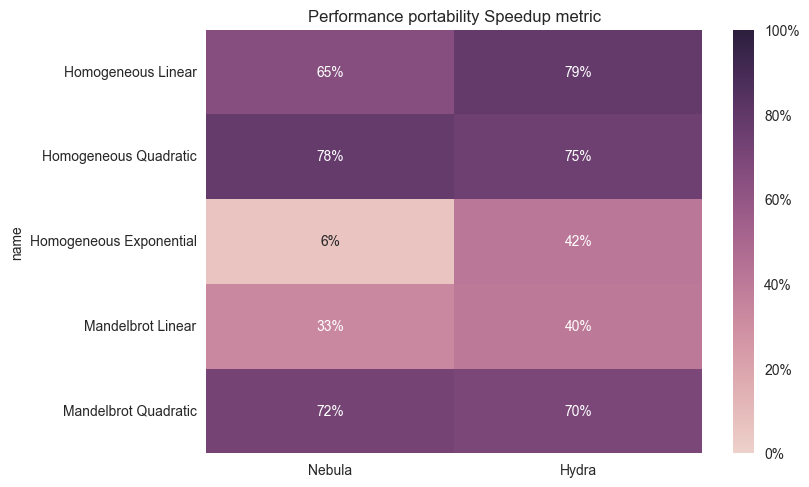

In [150]:
fmt = lambda x,pos: '{:.0%}'.format(x)
sns.heatmap(speed_pp, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1,cbar_kws={'format': FuncFormatter(fmt)},fmt='.0%',)

plt.title(f'Performance portability Speedup metric')

plot(f'Performance portability Speedup metric')

## Bps

### DATA

In [151]:
bsp_hypos = ['H4']

bps_pp = pd.concat([get_PP_df(hypo) for hypo in bsp_hypos])

bps_pp


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_51946/327932430.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['PP','name']), 1, inplace=True)
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_51946/327932430.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['PP','name']), 1, inplace=True)


,Nebula,Hydra
name,,
Merge Logic,0.293100,0.246422
Stable Sorting - Already Sorted,0.035507,0.327244
Stable Sorting - Descending Sorted,0.039425,0.807988
Stable Sorting - Not Sorted,0.043797,0.628399
Set Union Logic - One Empty,0.867175,0.830115
Set Union Logic - Wholly Greater,0.297941,0.256195
Set Union Logic - Front Overhand,0.677273,0.866313
Set Difference Logic - Left Empty,0.995286,0.953902
Set Difference Logic - Right Empty,0.884667,0.841641


### Plot

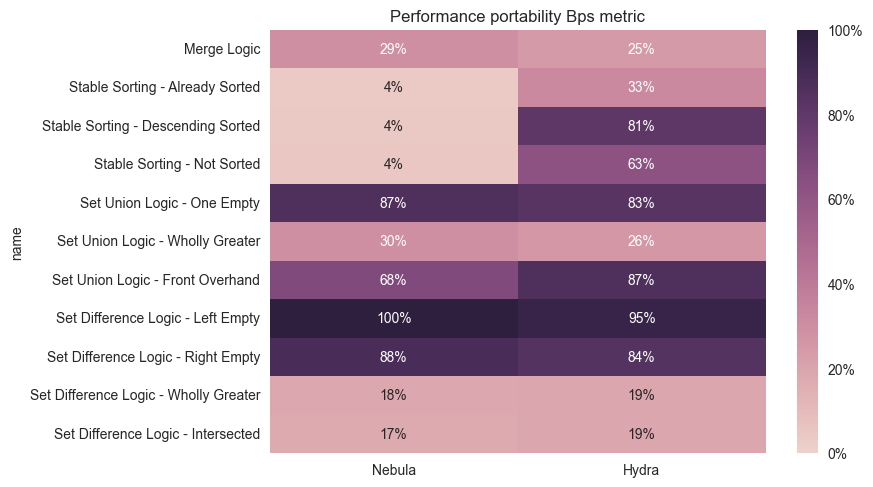

In [152]:
fmt = lambda x,pos: '{:.0%}'.format(x)
sns.heatmap(bps_pp, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1,cbar_kws={'format': FuncFormatter(fmt)},fmt='.0%',)

plt.title(f'Performance portability Bps metric')

plot(f'Performance  portability Bps metric')

## Runtime

### DATA

In [153]:
runtime_hypos = ['H5','H6','H7_REDUCED','H8']

runtime_pp = pd.concat([get_PP_df(hypo) for hypo in runtime_hypos])

runtime_pp


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_51946/327932430.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['PP','name']), 1, inplace=True)
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_51946/327932430.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['PP','name']), 1, inplace=True)
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_51946/327932430.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['PP','name']), 1, inplace=True)
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_51946/327932430.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except f

,Nebula,Hydra
name,,
Find Elements - First Entry,0.733743,0.544936
Find Elements - Last Entry,0.428797,0.559496
Find Elements - Non Existing,0.441176,0.662605
Vector Partition,0.033414,0.089660
Unique Copy,0.127524,0.122115
Min Max Elements - All Equal,0.446017,0.263432
Min Max Elements - Increasing,0.481193,0.292974
Inclusive Scan,0.364243,0.315675
Exclusive Scan,0.349065,0.313625


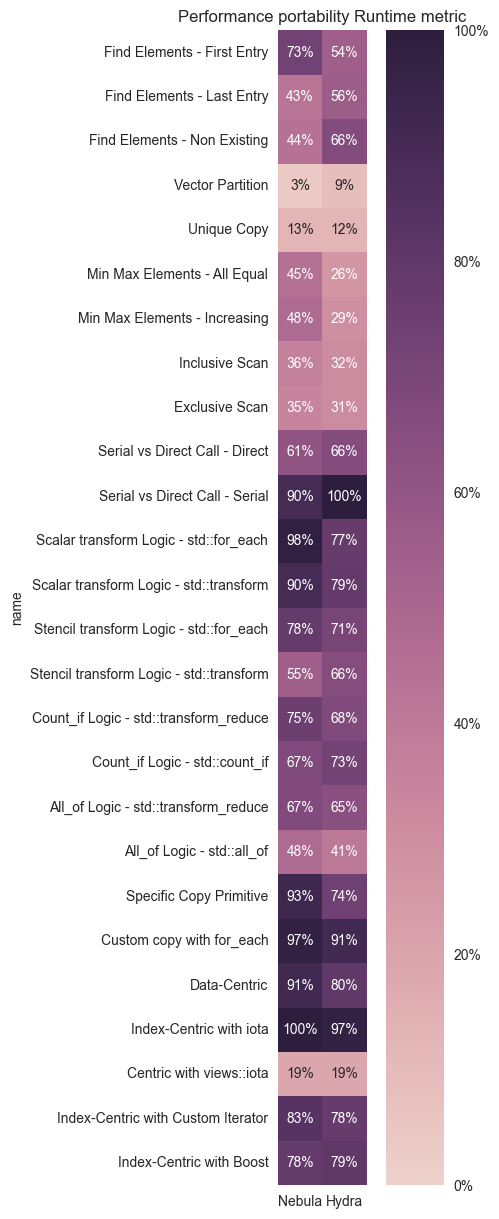

In [154]:
fig, ax = plt.subplots(figsize=(5,15))     # width , height     

fmt = lambda x,pos: '{:.0%}'.format(x)
sns.heatmap(runtime_pp, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1,cbar_kws={'format': FuncFormatter(fmt)},fmt='.0%',square=True,ax=ax,)

plt.title(f'Performance portability Runtime metric')

plot(f'Performance  portability Runtime metric')